# Testing model with estimation of stats for future games, impacts of models trained on different eras, and size of training data

In this round of testing we used the average of the past ten games to test our model on estimated data. We also tested with varying sizes and time periods of datasets as well as putting together validition vs test accuracy graphs in order to detect an underfitting or overfitting issues.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict

### Functions

Takes in a dataframe and team name, returns a dataframe containing all of the games for the requested team.

In [20]:
def pull_team(team, games):
    teams_games = games.loc[(games['TEAM_ABBREVIATION_HOME'] == team) |
                            (games['TEAM_ABBREVIATION_AWAY'] == team)]
    return teams_games


Returns the indices and values of all elements considered outliers by the tukey method.

In [21]:
def find_outliers(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    floor = q1 - 1.5 * iqr
    ceiling = q3 + 1.5 * iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values

drops the indices of games containing outliers in a statistical category

In [22]:
def remove_outliers(x):
    indices = []
    for c in x.columns:
        if not x[c].map(type).eq(str).any():
            if not c == "GAME_ID" or c == "GAME_DATE":
                indices += find_outliers(x[c])[0]
    x = x.drop(indices)
    return x

Separates teams into numerical and string columns, replaces missing numerical values with the median value of the statistic, and puts the two types of dataframes back together

In [23]:
def clean_team(x):
    # separate numerical features and categorical features
    categorical_columns = []
    numeric_columns = []
    for c in x.columns:
        if x[c].map(type).eq(str).any():
            categorical_columns.append(c)
        else:
            numeric_columns.append(c)

    # create two dataframes to hold the two types
    data_numeric = x[numeric_columns]
    data_categorical = pd.DataFrame(x[categorical_columns])

    # replace missing values in numerical columns with median and then add the two types back together
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    data_numeric = pd.DataFrame(imp.fit_transform(data_numeric), columns=data_numeric.columns, index=data_numeric.index)
    x = pd.concat([data_numeric, data_categorical], axis=1)
    return x

### Process

In [24]:
df = pd.read_csv('1990_2019.csv')
df['WL_HOME'] = [0 if x == 'L' else 1 for x in df['WL_HOME']]
print("number of games in 1990-2019 set: ",len(df))

number of games in 1990-2019 set:  34552


In [25]:
x = pull_team("MIN", df)
print("number of Minnesota games in 1990-2019 set pre removal: ", len(x))
x = clean_team(x)
x = remove_outliers(x)
print("number of Minnesota games in 1990-2019 set post removal: ", len(x))

number of Minnesota games in 1990-2019 set pre removal:  2364
number of Minnesota games in 1990-2019 set post removal:  1405


Drops columns of identifying information that does not affect outcome and separates the outcome into a separate dataframe.

In [26]:
teamIF = x.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
teamOF = x.WL_HOME

**Trained on full league, tested on single team (without outlier removal)**

In [27]:
league = clean_team(df)
leagueIF = league.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
leagueOF = league.WL_HOME

In [ ]:
leagueIF_train, leagueIF_test, leagueOF_train, leagueOF_test = train_test_split(leagueIF, leagueOF, test_size=.20)
scale = MinMaxScaler()
scale.fit(leagueIF_train)
leagueIF_train_scale = scale.transform(leagueIF_train)
leagueIF_test_scale = scale.transform(leagueIF_test)
league_svm = SVC(kernel = "rbf", gamma = .001)
league_svm.fit(leagueIF_train_scale, leagueOF_train)

In [ ]:
x = pull_team("MIN", df)
x = clean_team(x)
teamIF = x.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
teamOF = x.WL_HOME

In [ ]:
teamIF_train, teamIF_test, teamOF_train, teamOF_test = train_test_split(teamIF, teamOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(teamIF_train)
teamIF_train_scale = scale.transform(teamIF_train)
teamIF_test_scale = scale.transform(teamIF_test)

In [ ]:
pred = league_svm.predict(teamIF_test_scale)

In [ ]:
scores = cross_val_score(league_svm, teamIF, teamOF, cv=5)
print(classification_report(teamOF_test, pred))
print(league_svm.score(teamIF_test_scale, teamOF_test))

## Learning curve

In [ ]:

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": leagueIF,
    "y": leagueOF,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([league_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for SVM")

## validation curve

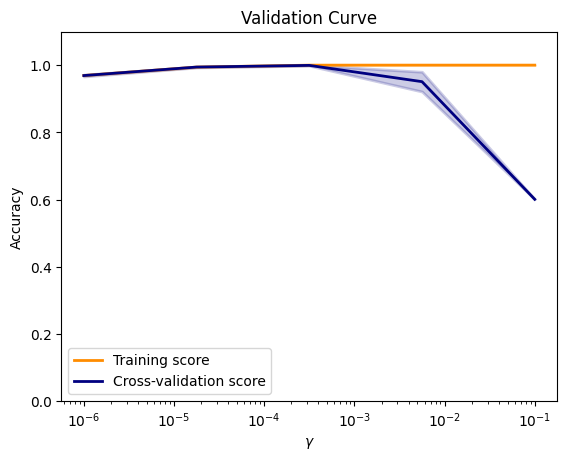

In [16]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\gamma$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

## validation curve

In [17]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="C",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\C$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

ValueError: 
\C
^
Unknown symbol: \C, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>

## validation curve

In [18]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="Kernel",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel("Kernel")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

ValueError: Invalid parameter 'Kernel' for estimator SVC(gamma=0.001). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

**Trained on single team test on single team (without outlier removal)**

In [ ]:
team_svm = SVC()
team_svm.fit(teamIF_train_scale, teamOF_train)
pred = team_svm.predict(teamIF_test_scale)

In [ ]:
print(classification_report(teamOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## Learning curve

In [ ]:

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": teamIF,
    "y": teamOF,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([team_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for SVM")

## validation curve

In [ ]:
X, y = teamIF, teamOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\gamma$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

## validation curve

In [ ]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="C",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\C$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

## validation curve

In [ ]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="Kernel",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel("Kernel")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

**Trained on single team tested on another team (without outlier removal)**

In [ ]:
g = pull_team('GSW',df)
g = clean_team(g)
gswIF = g.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
gswOF = g.WL_HOME

In [ ]:
gswIF_train, gswIF_test, gswOF_train, gswOF_test = train_test_split(gswIF, gswOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(gswIF_train)
gswIF_train_scale = scale.transform(gswIF_train)
gswIF_test_scale = scale.transform(gswIF_test)

In [ ]:
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

this time we test on a different team from the one we trained on. the f1 score is lower but to a lesser degree but the recall has taken a bit of a hit. the precision however has increased. This is to be expected since we are using one teams training for another team.

**Trained on single team tested on single team (wtih outlier removal)**

In [ ]:
x = remove_outliers(x)
teamIF = x.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
teamOF = x.WL_HOME
teamIF_train, teamIF_test, teamOF_train, teamOF_test = train_test_split(teamIF, teamOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(teamIF_train)
teamIF_train_scale = scale.transform(teamIF_train)
teamIF_test_scale = scale.transform(teamIF_test)
temp = SVC()
temp.fit(teamIF_train_scale, teamOF_train)
#pred = team_svm.predict(teamIF_test_scale)
pred = temp.predict(teamIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(teamOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

now with outliars removed we got the interesting case that across the board the stats were better (precision recall f1) removing the outlairs gave the SVM something more clean and reliable to work with.

**Trained on single team tested on another team (with outlier removal)**

In [ ]:
g = remove_outliers(g)
gswIF = g.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                    'TEAM_ABBREVIATION_AWAY'], axis=1)
gswOF = g.WL_HOME
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, gswIF, gswOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## Learning curve

In [ ]:

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": leagueIF,
    "y": leagueOF,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([league_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for SVM")

## validation curve

In [ ]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\gamma$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

## validation curve

In [ ]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="C",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\C$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

## validation curve

In [ ]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="Kernel",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel("Kernel")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

yet with outliar removal testing on a different team using training of the previous team seems to put us back at a f1 of 93%. but this can once again be explained by using one teams data to predict another team. here however the precision and recall are amazing.

## Transitional Era

In [ ]:
df = pd.read_csv('1995_2013.csv')
df['WL_HOME'] = [0 if x == 'L' else 1 for x in df['WL_HOME']]
print("number of games in 1995-2013 set: ",len(df))

Here we create a subeset of the dataset containing all of the games for the selected team from the dataset. We then check for any missing values in the dataframe and replace them with that team's average performance for that category. After doing so we check again for missing values to ensure that there are none.

In [ ]:
x = pull_team("MIN", df)
print("number of Minnesota games in 1990-2019 set pre removal: ", len(x))
x = clean_team(x)
x2 = remove_outliers(x)
print("number of Minnesota games in 1990-2019 set post removal: ", len(x))

**Trained on full league, tested on single team (without outlier removal)**

In [ ]:
league = clean_team(df)
leagueIF = league.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
leagueOF = league.WL_HOME

In [ ]:
leagueIF_train, leagueIF_test, leagueOF_train, leagueOF_test = train_test_split(leagueIF, leagueOF, test_size=.20)
scale = MinMaxScaler()
scale.fit(leagueIF_train)
leagueIF_train_scale = scale.transform(leagueIF_train)
leagueIF_test_scale = scale.transform(leagueIF_test)
league_svm = SVC()
league_svm.fit(leagueIF_train_scale, leagueOF_train)

In [ ]:
teamIF = x.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
teamOF = x.WL_HOME

In [ ]:
teamIF_train, teamIF_test, teamOF_train, teamOF_test = train_test_split(teamIF, teamOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(teamIF_train)
teamIF_train_scale = scale.transform(teamIF_train)
teamIF_test_scale = scale.transform(teamIF_test)

In [ ]:
pred = league_svm.predict(teamIF_test_scale)

In [ ]:
scores = cross_val_score(league_svm, teamIF, teamOF, cv=5)
print(classification_report(teamOF_test, pred))
print(league_svm.score(teamIF_test_scale, teamOF_test))

## Learning curve

In [ ]:

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": leagueIF,
    "y": leagueOF,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([league_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for SVM")

## validation curve

In [ ]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\gamma$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

**Trained on single team test on single team (without outlier removal)**

In [ ]:
team_svm = SVC()
team_svm.fit(teamIF_train_scale, teamOF_train)
pred = team_svm.predict(teamIF_test_scale)

In [ ]:
print(classification_report(teamOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## Learning curve

In [ ]:

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": teamIF,
    "y": teamOF,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([team_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for SVM")

## validation curve

In [ ]:
X, y = teamIF, teamOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\gamma$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

temp

**Trained on single team tested on another team (without outlier removal)**

In [ ]:
g = pull_team('GSW',df)
g = clean_team(g)
gswIF = g.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
gswOF = g.WL_HOME

In [ ]:
gswIF_train, gswIF_test, gswOF_train, gswOF_test = train_test_split(gswIF, gswOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(gswIF_train)
gswIF_train_scale = scale.transform(gswIF_train)
gswIF_test_scale = scale.transform(gswIF_test)

In [ ]:
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

temp

In [ ]:
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

**Trained on single team tested on single team (wtih outlier removal)**

In [ ]:
x = remove_outliers(x)
teamIF = x.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
teamOF = x.WL_HOME
teamIF_train, teamIF_test, teamOF_train, teamOF_test = train_test_split(teamIF, teamOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(teamIF_train)
teamIF_train_scale = scale.transform(teamIF_train)
teamIF_test_scale = scale.transform(teamIF_test)
temp = SVC()
temp.fit(teamIF_train_scale, teamOF_train)
#pred = team_svm.predict(teamIF_test_scale)
pred = temp.predict(teamIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(teamOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

temp

**Trained on single team tested on another team (with outlier removal)**

In [ ]:
g = remove_outliers(g)
gswIF = g.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                    'TEAM_ABBREVIATION_AWAY'], axis=1)
gswOF = g.WL_HOME
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, gswIF, gswOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

temp

## Modern Era

In [ ]:
 df = pd.read_csv('2013_2019.csv')
 df['WL_HOME'] = [0 if x == 'L' else 1 for x in df['WL_HOME']]

Here we create a subeset of the dataset containing all of the games for the selected team from the dataset. We then check for any missing values in the dataframe and replace them with that team's average performance for that category. After doing so we check again for missing values to ensure that there are none.

In [ ]:
x = pull_team("MIN", df)
x = clean_team(x)
x = remove_outliers(x)

**Trained on full league, tested on single team (without outlier removal)**

In [ ]:
league = clean_team(df)
leagueIF = league.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
leagueOF = league.WL_HOME

In [ ]:
leagueIF_train, leagueIF_test, leagueOF_train, leagueOF_test = train_test_split(leagueIF, leagueOF, test_size=.20)
scale = MinMaxScaler()
scale.fit(leagueIF_train)
leagueIF_train_scale = scale.transform(leagueIF_train)
leagueIF_test_scale = scale.transform(leagueIF_test)
league_svm = SVC()
league_svm.fit(leagueIF_train_scale, leagueOF_train)

In [ ]:
x = pull_team("MIN", df)
x = clean_team(x)
teamIF = x.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
teamOF = x.WL_HOME

In [ ]:
teamIF_train, teamIF_test, teamOF_train, teamOF_test = train_test_split(teamIF, teamOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(teamIF_train)
teamIF_train_scale = scale.transform(teamIF_train)
teamIF_test_scale = scale.transform(teamIF_test)

In [ ]:
pred = league_svm.predict(teamIF_test_scale)

In [ ]:
scores = cross_val_score(league_svm, teamIF, teamOF, cv=5)
print(classification_report(teamOF_test, pred))
print(league_svm.score(teamIF_test_scale, teamOF_test))

## Learning curve

In [ ]:

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": leagueIF,
    "y": leagueOF,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([league_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for SVM")

## validation curve

In [ ]:
X, y = leagueIF, leagueOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\gamma$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

so we train our SVM on the entire league and try to use that data to then predict the outcome for a single team. this is our baseline standard with the accuracy being at 85%. this is post pruning of outliars. 

**Trained on single team test on single team (without outlier removal)**

In [ ]:
team_svm = SVC()
team_svm.fit(teamIF_train_scale, teamOF_train)
pred = team_svm.predict(teamIF_test_scale)

In [ ]:
print(classification_report(teamOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## Learning curve

In [ ]:

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": teamIF,
    "y": teamOF,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([team_svm]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for SVM")

## validation curve

In [ ]:
X, y = teamIF, teamOF

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    league_svm,
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

pyplot.title("Validation Curve")
pyplot.xlabel(r"$\gamma$")
pyplot.ylabel("Accuracy")
pyplot.ylim(0.0, 1.1)
lw = 2
pyplot.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
pyplot.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
pyplot.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
pyplot.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
pyplot.legend(loc="best")
pyplot.show()

temp

**Trained on single team tested on another team (without outlier removal)**

In [ ]:
g = pull_team('GSW',df)
g = clean_team(g)
gswIF = g.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
gswOF = g.WL_HOME

In [ ]:
gswIF_train, gswIF_test, gswOF_train, gswOF_test = train_test_split(gswIF, gswOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(gswIF_train)
gswIF_train_scale = scale.transform(gswIF_train)
gswIF_test_scale = scale.transform(gswIF_test)

In [ ]:
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

temp

In [ ]:
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

**Trained on single team tested on single team (wtih outlier removal)**

In [ ]:
x = remove_outliers(x)
teamIF = x.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                        'TEAM_ABBREVIATION_AWAY', 'PTS_PAINT_HOME', 'PTS_PAINT_AWAY',
                        'PTS_2ND_CHANCE_AWAY','PTS_2ND_CHANCE_AWAY'], axis=1)
teamOF = x.WL_HOME
teamIF_train, teamIF_test, teamOF_train, teamOF_test = train_test_split(teamIF, teamOF, test_size=.25)
scale = MinMaxScaler()
scale.fit(teamIF_train)
teamIF_train_scale = scale.transform(teamIF_train)
teamIF_test_scale = scale.transform(teamIF_test)
temp = SVC()
temp.fit(teamIF_train_scale, teamOF_train)
#pred = team_svm.predict(teamIF_test_scale)
pred = temp.predict(teamIF_test_scale)
scores = cross_val_score(team_svm, teamIF, teamOF, cv=5)
print(classification_report(teamOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

temp

**Trained on single team tested on another team (with outlier removal)**

In [ ]:
g = remove_outliers(g)
gswIF = g.drop(['WL_HOME', 'GAME_ID', 'GAME_DATE', 'TEAM_ABBREVIATION_HOME',
                    'TEAM_ABBREVIATION_AWAY'], axis=1)
gswOF = g.WL_HOME
pred = team_svm.predict(gswIF_test_scale)
scores = cross_val_score(team_svm, gswIF, gswOF, cv=5)
print(classification_report(gswOF_test, pred))
print("score has %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))